In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [2]:

img1 = cv2.imread('disparity-1.png')
img2 = cv2.imread('disparity-2.png')


In [3]:

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)


In [4]:

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)


In [5]:

points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
points2 = np.float32([kp2[m.trainIdx].pt for m in matches])


In [6]:

F, mask = cv2.findFundamentalMat(points1, points2, method=cv2.FM_RANSAC)

points1 = points1[mask.ravel() == 1]
points2 = points2[mask.ravel() == 1]


In [7]:

focal_length = 800  
center = (img1.shape[1] / 2, img1.shape[0] / 2)

K = np.array([[focal_length, 0, center[0]],
              [0, focal_length, center[1]],
              [0, 0, 1]])


In [8]:


key_positions = np.array([
    [0, 0, 0],    
    [0, 0, 1],    
    [1, 0, 2],    
    [2, 1, 3],    
    [3, 2, 4]     
])



In [9]:

t = np.arange(len(key_positions))
spline = CubicSpline(t, key_positions, bc_type='natural')

t_spline = np.linspace(0, len(key_positions) - 1, 100)
spline_positions = spline(t_spline)


In [10]:

points_4d_list = []
for pos in spline_positions:
    
    R = np.eye(3)
    P = K @ np.hstack((R, pos.reshape(-1, 1))) 
    points_4d_hom = cv2.triangulatePoints(P, P, points1.T, points2.T)  
    points_4d_list.append(points_4d_hom)



In [11]:
points_3d = np.hstack([p[:3] / p[3] for p in points_4d_list])  

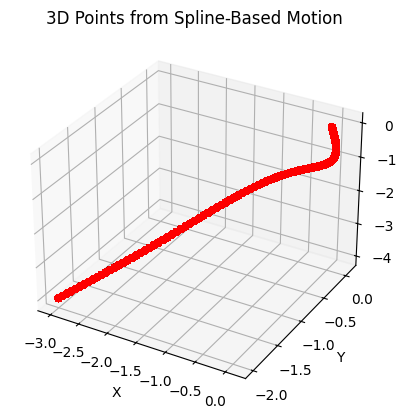

3D Points:
 [[ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 ...
 [-3.0000002 -2.        -4.       ]
 [-3.0000002 -2.        -4.       ]
 [-3.0000002 -2.        -4.       ]]


In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[0], points_3d[1], points_3d[2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Points from Spline-Based Motion')
plt.show()

print("3D Points:\n", points_3d.T)
